##### Copyright 2020 The TensorFlow Authors.

In [6]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multi-task recommenders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/recommenders/examples/multitask"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/recommenders/blob/main/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/recommenders/blob/main/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/recommenders/docs/examples/multitask.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In the [basic retrieval tutorial](basic_retrieval) we built a retrieval system using movie watches as positive interaction signals.

In many applications, however, there are multiple rich sources of feedback to draw upon. For example, an e-commerce site may record user visits to product pages (abundant, but relatively low signal), image clicks, adding to cart, and, finally, purchases. It may even record post-purchase signals such as reviews and returns.

Integrating all these different forms of feedback is critical to building systems that users love to use, and that do not optimize for any one metric at the expense of overall performance.

In addition, building a joint model for multiple tasks may produce better results than building a number of task-specific models. This is especially true where some data is abundant (for example, clicks), and some data is sparse (purchases, returns, manual reviews). In those scenarios, a joint model may be able to use representations learned from the abundant task to improve its predictions on the sparse task via a phenomenon known as [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). For example, [this paper](https://openreview.net/pdf?id=SJxPVcSonN) shows that a model predicting explicit user ratings from sparse user surveys can be substantially improved by adding an auxiliary task that uses abundant click log data.

In this tutorial, we are going to build a multi-objective recommender for Movielens, using both implicit (movie watches) and explicit signals (ratings).

## Imports


Let's first get our imports out of the way.


In [7]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

In [8]:
import os
import pprint
import tempfile

from typing import Dict, Text

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [9]:
import tensorflow_recommenders as tfrs

## Preparing the dataset

We're going to use the Movielens 100K dataset.

In [11]:
ratings = tfds.load('movielens/100k-ratings', split="train")
movies = tfds.load('movielens/100k-movies', split="train")

# Select the basic features.
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    #"movie_genres": x["movie_genres"],
    #"bucketized_user_age": x['bucketized_user_age'],
    #'raw_user_age': x['raw_user_age'],
    #'timestamp': x['timestamp'],
    #'user_gender': x['user_gender'],
    #'user_occupation_label': x['user_occupation_label'],
    #'user_zip_code': x['user_zip_code']
})
movies = movies.map(lambda x: x["movie_title"])

And repeat our preparations for building vocabularies and splitting the data into a train and a test set:

In [12]:
# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

movie_titles = movies.batch(1_000)
user_ids = ratings.batch(1_000_000).map(lambda x: x["user_id"])
#movie_genres = ratings.batch(1_000).map(lambda x: x['movie_genres'])

unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))
#unique_movie_genres = np.unique(np.concatenate(list(movie_genres)))

## A multi-task model

There are two critical parts to multi-task recommenders:

1. They optimize for two or more objectives, and so have two or more losses.
2. They share variables between the tasks, allowing for transfer learning.

In this tutorial, we will define our models as before, but instead of having  a single task, we will have two tasks: one that predicts ratings, and one that predicts movie watches.

The user and movie models are as before:

```python
user_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add 1 to account for the unknown token.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])
```

However, now we will have two tasks. The first is the rating task:

```python
tfrs.tasks.Ranking(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)
```

Its goal is to predict the ratings as accurately as possible.

The second is the retrieval task:

```python
tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128)
    )
)
```

As before, this task's goal is to predict which movies the user will or will not watch.

### Putting it together

We put it all together in a model class.

The new component here is that - since we have two tasks and two losses - we need to decide on how important each loss is. We can do this by giving each of the losses a weight, and treating these weights as hyperparameters. If we assign a large loss weight to the rating task, our model is going to focus on predicting ratings (but still use some information from the retrieval task); if we assign a large loss weight to the retrieval task, it will focus on retrieval instead.

In [13]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()

    self.user_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
    ])
    self.genre_embedding = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_movie_genres, mask_token=None),
        tf.keras.layers.Embedding(len(unique_movie_genres) + 1, 32),
    ])
    
  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.user_embedding(inputs["user_id"]),
        self.genre_embedding(inputs["timestamp"]),
    ], axis=1)

In [14]:
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [15]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
    # We take the loss weights in the constructor: this allows us to instantiate
    # several model objects with different loss weights.

    super().__init__()

    embedding_dimension = 32

    # User and movie models.
    self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
      tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
    ])
    self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
    ])


    # A small model to take in user and movie embeddings and predict ratings.
    # We can make this as complicated as we want as long as we output a scalar
    # as our prediction.
    self.rating_model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    # The tasks.
    self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.movie_model)
        )
    )

    # The loss weights.
    self.rating_weight = rating_weight
    self.retrieval_weight = retrieval_weight

  def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model.
    movie_embeddings = self.movie_model(features["movie_title"])
    # genres
    #genre_embeddings = self.movie_model(features['move_genres'])
    
    return (
        user_embeddings,
        movie_embeddings,
        #genre_embeddings,
        # We apply the multi-layered rating model to a concatentation of
        # user and movie embeddings.
        self.rating_model(
            tf.concat([user_embeddings, movie_embeddings,], axis=1) #genre_embeddings], axis=1)
        ),
    )

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

    ratings = features.pop("user_rating")

    user_embeddings, movie_embeddings, rating_predictions = self(features)#genre_embeddings, rating_predictions = self(features)

    # We compute the loss for each task.
    rating_loss = self.rating_task(
        labels=ratings,
        predictions=rating_predictions,
    )
    retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)#, genre_embeddings)

    # And combine them using the loss weights.
    return (self.rating_weight * rating_loss
            + self.retrieval_weight * retrieval_loss)

### Rating-specialized model

Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings.

In [16]:
#model = MovielensModel(rating_weight=1.0, retrieval_weight=0.0)
#model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [17]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [18]:
#model.fit(cached_train, epochs=3)
#metrics = model.evaluate(cached_test, return_dict=True)

#print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
#print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

The model does OK on predicting ratings (with an RMSE of around 1.11), but performs poorly at predicting which movies will be watched or not: its accuracy at 100 is almost 4 times worse than a model trained solely to predict watches.

### Retrieval-specialized model

Let's now try a model that focuses on retrieval only.

In [19]:
#model = MovielensModel(rating_weight=0.0, retrieval_weight=1.0)
#model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [20]:
#model.fit(cached_train, epochs=3)
#metrics = model.evaluate(cached_test, return_dict=True)

#print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
#print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

We get the opposite result: a model that does well on retrieval, but poorly on predicting ratings.

### Joint model

Let's now train a model that assigns positive weights to both tasks.

In [21]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

In [22]:
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 6s 413ms/step - root_mean_squared_error: 2.1022 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0045 - factorized_top_k/top_50_categorical_accuracy: 0.0531 - factorized_top_k/top_100_categorical_accuracy: 0.1201 - loss: 69826.2720 - regularization_loss: 0.0000e+00 - total_loss: 69826.2720
Epoch 2/50
10/10 [==============================] - 4s 399ms/step - root_mean_squared_error: 1.2918 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0124 - factorized_top_k/top_10_categorical_accuracy: 0.0265 - factorized_top_k/top_50_categorical_accuracy: 0.1398 - factorized_top_k/top_100_categorical_accuracy: 0.2590 - loss: 67478.8409 - regularization_loss: 0.0000e+00 - total_loss: 67478.8409
Epoch 3/50
10/10 [==============================] - 4s 403ms/step - root_mean_squared_error:

10/10 [==============================] - 4s 405ms/step - root_mean_squared_error: 0.9949 - factorized_top_k/top_1_categorical_accuracy: 8.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0342 - factorized_top_k/top_10_categorical_accuracy: 0.0699 - factorized_top_k/top_50_categorical_accuracy: 0.2624 - factorized_top_k/top_100_categorical_accuracy: 0.4109 - loss: 62910.0625 - regularization_loss: 0.0000e+00 - total_loss: 62910.0625
Epoch 20/50
10/10 [==============================] - 4s 405ms/step - root_mean_squared_error: 0.9918 - factorized_top_k/top_1_categorical_accuracy: 8.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0345 - factorized_top_k/top_10_categorical_accuracy: 0.0703 - factorized_top_k/top_50_categorical_accuracy: 0.2645 - factorized_top_k/top_100_categorical_accuracy: 0.4125 - loss: 62857.0724 - regularization_loss: 0.0000e+00 - total_loss: 62857.0724
Epoch 21/50
10/10 [==============================] - 4s 405ms/step - root_mean_squared_error: 0.98

10/10 [==============================] - 4s 415ms/step - root_mean_squared_error: 0.9606 - factorized_top_k/top_1_categorical_accuracy: 9.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0371 - factorized_top_k/top_10_categorical_accuracy: 0.0760 - factorized_top_k/top_50_categorical_accuracy: 0.2838 - factorized_top_k/top_100_categorical_accuracy: 0.4380 - loss: 62334.1495 - regularization_loss: 0.0000e+00 - total_loss: 62334.1495
Epoch 38/50
10/10 [==============================] - 4s 415ms/step - root_mean_squared_error: 0.9366 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0374 - factorized_top_k/top_10_categorical_accuracy: 0.0764 - factorized_top_k/top_50_categorical_accuracy: 0.2848 - factorized_top_k/top_100_categorical_accuracy: 0.4388 - loss: 62315.1509 - regularization_loss: 0.0000e+00 - total_loss: 62315.1509
Epoch 39/50
10/10 [==============================] - 4s 410ms/step - root_mean_squared_error: 0.9224 -

In [49]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))
adaOhOne = model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)


#************************


print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 5s 411ms/step - root_mean_squared_error: 3.1496 - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0027 - factorized_top_k/top_10_categorical_accuracy: 0.0053 - factorized_top_k/top_50_categorical_accuracy: 0.0283 - factorized_top_k/top_100_categorical_accuracy: 0.0566 - loss: 70377.7912 - regularization_loss: 0.0000e+00 - total_loss: 70377.7912
Epoch 2/50
10/10 [==============================] - 4s 408ms/step - root_mean_squared_error: 1.6215 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0058 - factorized_top_k/top_10_categorical_accuracy: 0.0118 - factorized_top_k/top_50_categorical_accuracy: 0.0531 - factorized_top_k/top_100_categorical_accuracy: 0.0963 - loss: 70359.5206 - regularization_loss: 0.0000e+00 - total_loss: 70359.5206
Epoch 3/50
10/10 [==============================] - 4s 413ms/step - root_mean_squared_er

10/10 [==============================] - 4s 416ms/step - root_mean_squared_error: 1.0392 - factorized_top_k/top_1_categorical_accuracy: 5.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0246 - factorized_top_k/top_10_categorical_accuracy: 0.0517 - factorized_top_k/top_50_categorical_accuracy: 0.2043 - factorized_top_k/top_100_categorical_accuracy: 0.3318 - loss: 68224.3196 - regularization_loss: 0.0000e+00 - total_loss: 68224.3196
Epoch 19/50
10/10 [==============================] - 4s 417ms/step - root_mean_squared_error: 1.0375 - factorized_top_k/top_1_categorical_accuracy: 4.6250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0246 - factorized_top_k/top_10_categorical_accuracy: 0.0517 - factorized_top_k/top_50_categorical_accuracy: 0.2035 - factorized_top_k/top_100_categorical_accuracy: 0.3310 - loss: 68131.0795 - regularization_loss: 0.0000e+00 - total_loss: 68131.0795
Epoch 20/50
10/10 [==============================] - 4s 446ms/step - root_mean_squared_error: 1.03

10/10 [==============================] - 4s 423ms/step - root_mean_squared_error: 1.0179 - factorized_top_k/top_1_categorical_accuracy: 8.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0240 - factorized_top_k/top_10_categorical_accuracy: 0.0492 - factorized_top_k/top_50_categorical_accuracy: 0.1986 - factorized_top_k/top_100_categorical_accuracy: 0.3259 - loss: 67194.9261 - regularization_loss: 0.0000e+00 - total_loss: 67194.9261
Epoch 36/50
10/10 [==============================] - 4s 443ms/step - root_mean_squared_error: 1.0170 - factorized_top_k/top_1_categorical_accuracy: 8.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0242 - factorized_top_k/top_10_categorical_accuracy: 0.0494 - factorized_top_k/top_50_categorical_accuracy: 0.1988 - factorized_top_k/top_100_categorical_accuracy: 0.3262 - loss: 67155.8217 - regularization_loss: 0.0000e+00 - total_loss: 67155.8217
Epoch 37/50
10/10 [==============================] - 4s 420ms/step - root_mean_squared_error: 1.01

In [24]:
#model.get_config()

In [25]:
#model.save('adaOhOne.h5')

In [26]:
adaOhOne = pd.DataFrame(adaOhOne.history)
adaOhOne

,root_mean_squared_error,factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss
0,3.288998,0.000012,0.002325,0.005000,0.027275,0.056075,54849.933594,0,54849.933594
1,1.953145,0.000025,0.005925,0.012362,0.055512,0.103013,54830.937500,0,54830.937500
2,1.171531,0.000000,0.013875,0.028937,0.118425,0.197262,54798.488281,0,54798.488281
3,1.134231,0.000000,0.018675,0.040787,0.177075,0.291638,54733.171875,0,54733.171875
4,1.126864,0.000200,0.020913,0.045550,0.197425,0.323287,54630.246094,0,54630.246094
5,1.111921,0.000550,0.022350,0.047812,0.202912,0.330462,54497.359375,0,54497.359375
6,1.094067,0.000100,0.022287,0.047625,0.202975,0.330563,54347.066406,0,54347.066406


In [27]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.001))
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 6s 451ms/step - root_mean_squared_error: 3.6430 - factorized_top_k/top_1_categorical_accuracy: 3.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0024 - factorized_top_k/top_10_categorical_accuracy: 0.0051 - factorized_top_k/top_50_categorical_accuracy: 0.0291 - factorized_top_k/top_100_categorical_accuracy: 0.0584 - loss: 70380.8089 - regularization_loss: 0.0000e+00 - total_loss: 70380.8089
Epoch 2/50
10/10 [==============================] - 4s 416ms/step - root_mean_squared_error: 3.5899 - factorized_top_k/top_1_categorical_accuracy: 8.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0025 - factorized_top_k/top_10_categorical_accuracy: 0.0054 - factorized_top_k/top_50_categorical_accuracy: 0.0307 - factorized_top_k/top_100_categorical_accuracy: 0.0610 - loss: 70379.5668 - regularization_loss: 0.0000e+00 - total_loss: 70379.5668
Epoch 3/50
10/10 [==============================] - 4s 414ms/step - root_mean_squared_er

10/10 [==============================] - 4s 449ms/step - root_mean_squared_error: 2.8003 - factorized_top_k/top_1_categorical_accuracy: 6.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0049 - factorized_top_k/top_10_categorical_accuracy: 0.0104 - factorized_top_k/top_50_categorical_accuracy: 0.0476 - factorized_top_k/top_100_categorical_accuracy: 0.0911 - loss: 70366.9112 - regularization_loss: 0.0000e+00 - total_loss: 70366.9112
Epoch 19/50
10/10 [==============================] - 5s 460ms/step - root_mean_squared_error: 2.7379 - factorized_top_k/top_1_categorical_accuracy: 2.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0107 - factorized_top_k/top_50_categorical_accuracy: 0.0486 - factorized_top_k/top_100_categorical_accuracy: 0.0929 - loss: 70366.1463 - regularization_loss: 0.0000e+00 - total_loss: 70366.1463
Epoch 20/50
10/10 [==============================] - 5s 468ms/step - root_mean_squared_error: 2.67

10/10 [==============================] - 4s 423ms/step - root_mean_squared_error: 1.7410 - factorized_top_k/top_1_categorical_accuracy: 1.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0083 - factorized_top_k/top_10_categorical_accuracy: 0.0170 - factorized_top_k/top_50_categorical_accuracy: 0.0693 - factorized_top_k/top_100_categorical_accuracy: 0.1235 - loss: 70354.4034 - regularization_loss: 0.0000e+00 - total_loss: 70354.4034
Epoch 36/50
10/10 [==============================] - 4s 450ms/step - root_mean_squared_error: 1.6904 - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0086 - factorized_top_k/top_10_categorical_accuracy: 0.0176 - factorized_top_k/top_50_categorical_accuracy: 0.0707 - factorized_top_k/top_100_categorical_accuracy: 0.1253 - loss: 70353.7209 - regularization_loss: 0.0000e+00 - total_loss: 70353.7209
Epoch 37/50
10/10 [==============================] - 5s 460ms/step - root_mean_squared_error: 1.64

In [28]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adam(0.1))
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 5s 442ms/step - root_mean_squared_error: 9.2875 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 7.7500e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0020 - factorized_top_k/top_50_categorical_accuracy: 0.0215 - factorized_top_k/top_100_categorical_accuracy: 0.0556 - loss: 69974.8082 - regularization_loss: 0.0000e+00 - total_loss: 69974.8082
Epoch 2/50
10/10 [==============================] - 4s 420ms/step - root_mean_squared_error: 3.6376 - factorized_top_k/top_1_categorical_accuracy: 5.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0117 - factorized_top_k/top_10_categorical_accuracy: 0.0252 - factorized_top_k/top_50_categorical_accuracy: 0.1285 - factorized_top_k/top_100_categorical_accuracy: 0.2391 - loss: 66757.0866 - regularization_loss: 0.0000e+00 - total_loss: 66757.0866
Epoch 3/50
10/10 [==============================] - 4s 434ms/step - root_mean_square

10/10 [==============================] - 4s 424ms/step - root_mean_squared_error: 1.1259 - factorized_top_k/top_1_categorical_accuracy: 0.0015 - factorized_top_k/top_5_categorical_accuracy: 0.0283 - factorized_top_k/top_10_categorical_accuracy: 0.0716 - factorized_top_k/top_50_categorical_accuracy: 0.3113 - factorized_top_k/top_100_categorical_accuracy: 0.4742 - loss: 62245.8416 - regularization_loss: 0.0000e+00 - total_loss: 62245.8416
Epoch 20/50
10/10 [==============================] - 4s 437ms/step - root_mean_squared_error: 1.1259 - factorized_top_k/top_1_categorical_accuracy: 0.0017 - factorized_top_k/top_5_categorical_accuracy: 0.0289 - factorized_top_k/top_10_categorical_accuracy: 0.0722 - factorized_top_k/top_50_categorical_accuracy: 0.3120 - factorized_top_k/top_100_categorical_accuracy: 0.4756 - loss: 62232.9975 - regularization_loss: 0.0000e+00 - total_loss: 62232.9975
Epoch 21/50
10/10 [==============================] - 5s 469ms/step - root_mean_squared_error: 1.1259 - fac

10/10 [==============================] - 4s 437ms/step - root_mean_squared_error: 1.1259 - factorized_top_k/top_1_categorical_accuracy: 0.0016 - factorized_top_k/top_5_categorical_accuracy: 0.0279 - factorized_top_k/top_10_categorical_accuracy: 0.0715 - factorized_top_k/top_50_categorical_accuracy: 0.3244 - factorized_top_k/top_100_categorical_accuracy: 0.4870 - loss: 62050.8200 - regularization_loss: 0.0000e+00 - total_loss: 62050.8200
Epoch 38/50
10/10 [==============================] - 4s 416ms/step - root_mean_squared_error: 1.1259 - factorized_top_k/top_1_categorical_accuracy: 0.0018 - factorized_top_k/top_5_categorical_accuracy: 0.0285 - factorized_top_k/top_10_categorical_accuracy: 0.0712 - factorized_top_k/top_50_categorical_accuracy: 0.3249 - factorized_top_k/top_100_categorical_accuracy: 0.4886 - loss: 62045.2603 - regularization_loss: 0.0000e+00 - total_loss: 62045.2603
Epoch 39/50
10/10 [==============================] - 4s 437ms/step - root_mean_squared_error: 1.1259 - fac

In [29]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 5s 414ms/step - root_mean_squared_error: 2.2767 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0037 - factorized_top_k/top_50_categorical_accuracy: 0.0244 - factorized_top_k/top_100_categorical_accuracy: 0.0539 - loss: 70369.3061 - regularization_loss: 0.0000e+00 - total_loss: 70369.3061
Epoch 2/50
10/10 [==============================] - 4s 413ms/step - root_mean_squared_error: 1.3214 - factorized_top_k/top_1_categorical_accuracy: 8.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0141 - factorized_top_k/top_10_categorical_accuracy: 0.0327 - factorized_top_k/top_50_categorical_accuracy: 0.1530 - factorized_top_k/top_100_categorical_accuracy: 0.2665 - loss: 70130.6776 - regularization_loss: 0.0000e+00 - total_loss: 70130.6776
Epoch 3/50
10/10 [==============================] - 4s 414ms/step - root_mean_squared_er

10/10 [==============================] - 4s 440ms/step - root_mean_squared_error: 0.9021 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0340 - factorized_top_k/top_10_categorical_accuracy: 0.0685 - factorized_top_k/top_50_categorical_accuracy: 0.2515 - factorized_top_k/top_100_categorical_accuracy: 0.3959 - loss: 63170.6804 - regularization_loss: 0.0000e+00 - total_loss: 63170.6804
Epoch 19/50
10/10 [==============================] - 4s 421ms/step - root_mean_squared_error: 0.8962 - factorized_top_k/top_1_categorical_accuracy: 0.0011 - factorized_top_k/top_5_categorical_accuracy: 0.0345 - factorized_top_k/top_10_categorical_accuracy: 0.0694 - factorized_top_k/top_50_categorical_accuracy: 0.2550 - factorized_top_k/top_100_categorical_accuracy: 0.4008 - loss: 63067.4751 - regularization_loss: 0.0000e+00 - total_loss: 63067.4751
Epoch 20/50
10/10 [==============================] - 4s 416ms/step - root_mean_squared_error: 0.8934 - fac

10/10 [==============================] - 4s 439ms/step - root_mean_squared_error: 0.8824 - factorized_top_k/top_1_categorical_accuracy: 6.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0384 - factorized_top_k/top_10_categorical_accuracy: 0.0787 - factorized_top_k/top_50_categorical_accuracy: 0.2899 - factorized_top_k/top_100_categorical_accuracy: 0.4462 - loss: 62174.4205 - regularization_loss: 0.0000e+00 - total_loss: 62174.4205
Epoch 37/50
10/10 [==============================] - 5s 452ms/step - root_mean_squared_error: 0.8686 - factorized_top_k/top_1_categorical_accuracy: 6.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0385 - factorized_top_k/top_10_categorical_accuracy: 0.0791 - factorized_top_k/top_50_categorical_accuracy: 0.2914 - factorized_top_k/top_100_categorical_accuracy: 0.4476 - loss: 62145.5483 - regularization_loss: 0.0000e+00 - total_loss: 62145.5483
Epoch 38/50
10/10 [==============================] - 4s 425ms/step - root_mean_squared_error: 0.84

In [50]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001))
adamOhOhOne = model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)


#*****************************

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 5s 418ms/step - root_mean_squared_error: 3.5949 - factorized_top_k/top_1_categorical_accuracy: 1.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0021 - factorized_top_k/top_10_categorical_accuracy: 0.0049 - factorized_top_k/top_50_categorical_accuracy: 0.0280 - factorized_top_k/top_100_categorical_accuracy: 0.0565 - loss: 70380.5753 - regularization_loss: 0.0000e+00 - total_loss: 70380.5753
Epoch 2/50
10/10 [==============================] - 4s 451ms/step - root_mean_squared_error: 3.2253 - factorized_top_k/top_1_categorical_accuracy: 6.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0033 - factorized_top_k/top_10_categorical_accuracy: 0.0077 - factorized_top_k/top_50_categorical_accuracy: 0.0393 - factorized_top_k/top_100_categorical_accuracy: 0.0746 - loss: 70372.5526 - regularization_loss: 0.0000e+00 - total_loss: 70372.5526
Epoch 3/50
10/10 [==============================] - 4s 421ms/step - root_mean_squared_er

10/10 [==============================] - 4s 425ms/step - root_mean_squared_error: 1.0102 - factorized_top_k/top_1_categorical_accuracy: 4.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0252 - factorized_top_k/top_10_categorical_accuracy: 0.0530 - factorized_top_k/top_50_categorical_accuracy: 0.2123 - factorized_top_k/top_100_categorical_accuracy: 0.3430 - loss: 68905.3764 - regularization_loss: 0.0000e+00 - total_loss: 68905.3764
Epoch 19/50
10/10 [==============================] - 4s 424ms/step - root_mean_squared_error: 1.0071 - factorized_top_k/top_1_categorical_accuracy: 2.7500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0254 - factorized_top_k/top_10_categorical_accuracy: 0.0524 - factorized_top_k/top_50_categorical_accuracy: 0.2108 - factorized_top_k/top_100_categorical_accuracy: 0.3407 - loss: 68721.7855 - regularization_loss: 0.0000e+00 - total_loss: 68721.7855
Epoch 20/50
10/10 [==============================] - 5s 483ms/step - root_mean_squared_error: 1.00

10/10 [==============================] - 4s 425ms/step - root_mean_squared_error: 0.9680 - factorized_top_k/top_1_categorical_accuracy: 3.7500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0230 - factorized_top_k/top_10_categorical_accuracy: 0.0488 - factorized_top_k/top_50_categorical_accuracy: 0.2016 - factorized_top_k/top_100_categorical_accuracy: 0.3262 - loss: 66834.6378 - regularization_loss: 0.0000e+00 - total_loss: 66834.6378
Epoch 36/50
10/10 [==============================] - 4s 422ms/step - root_mean_squared_error: 0.9658 - factorized_top_k/top_1_categorical_accuracy: 3.1250e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0235 - factorized_top_k/top_10_categorical_accuracy: 0.0495 - factorized_top_k/top_50_categorical_accuracy: 0.2024 - factorized_top_k/top_100_categorical_accuracy: 0.3270 - loss: 66759.0114 - regularization_loss: 0.0000e+00 - total_loss: 66759.0114
Epoch 37/50
10/10 [==============================] - 5s 459ms/step - root_mean_squared_error: 0.96

In [31]:
adamOhOhOne = pd.DataFrame(adamOhOhOne.history)
adamOhOhOne

,root_mean_squared_error,factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss
0,3.569984,0.000112,0.002650,0.005700,0.028413,0.057937,54854.332031,0,54854.332031
1,3.125036,0.000087,0.003975,0.008750,0.039437,0.076537,54847.378906,0,54847.378906
2,2.264843,0.000012,0.005675,0.011700,0.050925,0.095875,54838.175781,0,54838.175781
3,1.284054,0.000025,0.008375,0.016425,0.066375,0.120325,54831.042969,0,54831.042969
4,1.282530,0.000000,0.011475,0.022412,0.089175,0.149725,54822.332031,0,54822.332031
5,1.100013,0.000050,0.015650,0.030963,0.116125,0.190388,54809.097656,0,54809.097656
6,1.090638,0.000112,0.020188,0.040650,0.148388,0.237538,54788.785156,0,54788.785156
7,1.069134,0.000225,0.023675,0.048637,0.180425,0.283475,54758.261719,0,54758.261719
8,1.059724,0.000762,0.025888,0.053025,0.202150,0.318363,54714.082031,0,54714.082031
9,1.047601,0.000000,0.025725,0.053112,0.211087,0.336163,54653.179688,0,54653.179688


In [32]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001))
rmsOhOhOne = model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

#**************************

rmsOhOhOne = pd.DataFrame(rmsOhOhOne.history)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 6s 438ms/step - root_mean_squared_error: 3.3250 - factorized_top_k/top_1_categorical_accuracy: 6.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0023 - factorized_top_k/top_10_categorical_accuracy: 0.0049 - factorized_top_k/top_50_categorical_accuracy: 0.0278 - factorized_top_k/top_100_categorical_accuracy: 0.0581 - loss: 70378.5973 - regularization_loss: 0.0000e+00 - total_loss: 70378.5973
Epoch 2/50
10/10 [==============================] - 4s 440ms/step - root_mean_squared_error: 2.1429 - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0041 - factorized_top_k/top_10_categorical_accuracy: 0.0088 - factorized_top_k/top_50_categorical_accuracy: 0.0440 - factorized_top_k/top_100_categorical_accuracy: 0.0841 - loss: 70364.7109 - regularization_loss: 0.0000e+00 - total_loss: 70364.7109
Epoch 3/50
10/10 [==============================] - 4s 445ms/step - root_mean_squared_er

10/10 [==============================] - 5s 469ms/step - root_mean_squared_error: 1.0177 - factorized_top_k/top_1_categorical_accuracy: 2.5000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0233 - factorized_top_k/top_10_categorical_accuracy: 0.0494 - factorized_top_k/top_50_categorical_accuracy: 0.2019 - factorized_top_k/top_100_categorical_accuracy: 0.3323 - loss: 69318.1960 - regularization_loss: 0.0000e+00 - total_loss: 69318.1960
Epoch 19/50
10/10 [==============================] - 5s 461ms/step - root_mean_squared_error: 1.0176 - factorized_top_k/top_1_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0230 - factorized_top_k/top_10_categorical_accuracy: 0.0492 - factorized_top_k/top_50_categorical_accuracy: 0.2016 - factorized_top_k/top_100_categorical_accuracy: 0.3307 - loss: 69207.1697 - regularization_loss: 0.0000e+00 - total_loss: 69207.1697
Epoch 20/50
10/10 [==============================] - 5s 460ms/step - root_mean_squared_error: 1.01

10/10 [==============================] - 4s 438ms/step - root_mean_squared_error: 0.9958 - factorized_top_k/top_1_categorical_accuracy: 7.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0213 - factorized_top_k/top_10_categorical_accuracy: 0.0443 - factorized_top_k/top_50_categorical_accuracy: 0.1866 - factorized_top_k/top_100_categorical_accuracy: 0.3120 - loss: 67700.0220 - regularization_loss: 0.0000e+00 - total_loss: 67700.0220
Epoch 36/50
10/10 [==============================] - 5s 461ms/step - root_mean_squared_error: 1.0009 - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0209 - factorized_top_k/top_10_categorical_accuracy: 0.0438 - factorized_top_k/top_50_categorical_accuracy: 0.1852 - factorized_top_k/top_100_categorical_accuracy: 0.3109 - loss: 67627.5810 - regularization_loss: 0.0000e+00 - total_loss: 67627.5810
Epoch 37/50
10/10 [==============================] - 4s 419ms/step - root_mean_squared_error: 0.99

In [35]:
rmsOhOhOne

,root_mean_squared_error,factorized_top_k/top_1_categorical_accuracy,factorized_top_k/top_5_categorical_accuracy,factorized_top_k/top_10_categorical_accuracy,factorized_top_k/top_50_categorical_accuracy,factorized_top_k/top_100_categorical_accuracy,loss,regularization_loss,total_loss
0,3.325034,0.000063,0.002313,0.004875,0.027787,0.058100,54850.746094,0,54850.746094
1,2.142920,0.000050,0.004050,0.008763,0.044000,0.084125,54839.691406,0,54839.691406
2,1.232760,0.000075,0.006825,0.014475,0.062825,0.113537,54831.464844,0,54831.464844
3,1.107500,0.000050,0.011288,0.022150,0.089975,0.153375,54820.328125,0,54820.328125
4,1.080956,0.000388,0.016225,0.031688,0.125137,0.206275,54803.410156,0,54803.410156
5,1.064817,0.000125,0.019350,0.039212,0.156250,0.255163,54779.136719,0,54779.136719
6,1.055693,0.000188,0.021662,0.044325,0.179888,0.293775,54746.566406,0,54746.566406
7,1.050477,0.000125,0.022363,0.046737,0.192600,0.315550,54705.226562,0,54705.226562
8,1.045479,0.000025,0.022788,0.047288,0.198200,0.326237,54655.312500,0,54655.312500
9,1.038926,0.000175,0.023363,0.048775,0.202863,0.332500,54597.226562,0,54597.226562


In [36]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.01))
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 6s 403ms/step - root_mean_squared_error: 2.3321 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0014 - factorized_top_k/top_10_categorical_accuracy: 0.0044 - factorized_top_k/top_50_categorical_accuracy: 0.0399 - factorized_top_k/top_100_categorical_accuracy: 0.0886 - loss: 70279.8949 - regularization_loss: 0.0000e+00 - total_loss: 70279.8949
Epoch 2/50
10/10 [==============================] - 4s 407ms/step - root_mean_squared_error: 1.6464 - factorized_top_k/top_1_categorical_accuracy: 6.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0065 - factorized_top_k/top_10_categorical_accuracy: 0.0199 - factorized_top_k/top_50_categorical_accuracy: 0.1298 - factorized_top_k/top_100_categorical_accuracy: 0.2468 - loss: 69166.3232 - regularization_loss: 0.0000e+00 - total_loss: 69166.3232
Epoch 3/50
10/10 [==============================] - 4s 413ms/step - root_mean_squared_er

10/10 [==============================] - 4s 419ms/step - root_mean_squared_error: 1.0926 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0314 - factorized_top_k/top_10_categorical_accuracy: 0.0650 - factorized_top_k/top_50_categorical_accuracy: 0.2426 - factorized_top_k/top_100_categorical_accuracy: 0.3826 - loss: 63596.5952 - regularization_loss: 0.0000e+00 - total_loss: 63596.5952
Epoch 20/50
10/10 [==============================] - 4s 426ms/step - root_mean_squared_error: 1.0667 - factorized_top_k/top_1_categorical_accuracy: 9.8750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0315 - factorized_top_k/top_10_categorical_accuracy: 0.0656 - factorized_top_k/top_50_categorical_accuracy: 0.2442 - factorized_top_k/top_100_categorical_accuracy: 0.3854 - loss: 63499.0732 - regularization_loss: 0.0000e+00 - total_loss: 63499.0732
Epoch 21/50
10/10 [==============================] - 4s 421ms/step - root_mean_squared_error: 1.0743 -

10/10 [==============================] - 4s 433ms/step - root_mean_squared_error: 0.9827 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0349 - factorized_top_k/top_10_categorical_accuracy: 0.0715 - factorized_top_k/top_50_categorical_accuracy: 0.2737 - factorized_top_k/top_100_categorical_accuracy: 0.4264 - loss: 62610.6463 - regularization_loss: 0.0000e+00 - total_loss: 62610.6463
Epoch 38/50
10/10 [==============================] - 4s 426ms/step - root_mean_squared_error: 0.9657 - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0354 - factorized_top_k/top_10_categorical_accuracy: 0.0722 - factorized_top_k/top_50_categorical_accuracy: 0.2747 - factorized_top_k/top_100_categorical_accuracy: 0.4285 - loss: 62581.3956 - regularization_loss: 0.0000e+00 - total_loss: 62581.3956
Epoch 39/50
10/10 [==============================] - 4s 424ms/step - root_mean_squared_error: 1.0269 - fac

In [37]:
model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.1))
model.fit(cached_train, epochs=50)
metrics = model.evaluate(cached_test, return_dict=True)


print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/50
10/10 [==============================] - 6s 471ms/step - root_mean_squared_error: 249.8298 - factorized_top_k/top_1_categorical_accuracy: 3.3750e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0029 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accuracy: 0.0305 - factorized_top_k/top_100_categorical_accuracy: 0.0623 - loss: 126293.7528 - regularization_loss: 0.0000e+00 - total_loss: 126293.7528
Epoch 2/50
10/10 [==============================] - 5s 464ms/step - root_mean_squared_error: 2.0819 - factorized_top_k/top_1_categorical_accuracy: 1.2500e-05 - factorized_top_k/top_5_categorical_accuracy: 0.0028 - factorized_top_k/top_10_categorical_accuracy: 0.0063 - factorized_top_k/top_50_categorical_accuracy: 0.0341 - factorized_top_k/top_100_categorical_accuracy: 0.0724 - loss: 70157.4347 - regularization_loss: 0.0000e+00 - total_loss: 70157.4347
Epoch 3/50
10/10 [==============================] - 5s 462ms/step - root_mean_square

10/10 [==============================] - 4s 420ms/step - root_mean_squared_error: 1.1414 - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0181 - factorized_top_k/top_10_categorical_accuracy: 0.0427 - factorized_top_k/top_50_categorical_accuracy: 0.2167 - factorized_top_k/top_100_categorical_accuracy: 0.3647 - loss: 64925.4162 - regularization_loss: 0.0000e+00 - total_loss: 64925.4162
Epoch 20/50
10/10 [==============================] - 4s 418ms/step - root_mean_squared_error: 1.1029 - factorized_top_k/top_1_categorical_accuracy: 0.0014 - factorized_top_k/top_5_categorical_accuracy: 0.0184 - factorized_top_k/top_10_categorical_accuracy: 0.0424 - factorized_top_k/top_50_categorical_accuracy: 0.2175 - factorized_top_k/top_100_categorical_accuracy: 0.3661 - loss: 64905.3153 - regularization_loss: 0.0000e+00 - total_loss: 64905.3153
Epoch 21/50
10/10 [==============================] - 4s 418ms/step - root_mean_squared_error: 1.1044 - fac

10/10 [==============================] - 5s 455ms/step - root_mean_squared_error: 1.2183 - factorized_top_k/top_1_categorical_accuracy: 0.0013 - factorized_top_k/top_5_categorical_accuracy: 0.0182 - factorized_top_k/top_10_categorical_accuracy: 0.0435 - factorized_top_k/top_50_categorical_accuracy: 0.2230 - factorized_top_k/top_100_categorical_accuracy: 0.3763 - loss: 64784.5625 - regularization_loss: 0.0000e+00 - total_loss: 64784.5625
Epoch 38/50
10/10 [==============================] - 5s 465ms/step - root_mean_squared_error: 1.1275 - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0183 - factorized_top_k/top_10_categorical_accuracy: 0.0432 - factorized_top_k/top_50_categorical_accuracy: 0.2234 - factorized_top_k/top_100_categorical_accuracy: 0.3759 - loss: 64789.7528 - regularization_loss: 0.0000e+00 - total_loss: 64789.7528
Epoch 39/50
10/10 [==============================] - 4s 416ms/step - root_mean_squared_error: 1.1258 - fac

In [57]:
adaOhOne.history['factorized_top_k/top_100_categorical_accuracy']

[0.05662500113248825,
 0.09629999846220016,
 0.1764875054359436,
 0.2833249866962433,
 0.33338749408721924,
 0.34255000948905945,
 0.34536251425743103,
 0.34353750944137573,
 0.34220001101493835,
 0.33951249718666077,
 0.33841249346733093,
 0.33723750710487366,
 0.3356125056743622,
 0.3351125121116638,
 0.334199994802475,
 0.3333374857902527,
 0.3324500024318695,
 0.3318125009536743,
 0.3310374915599823,
 0.33031249046325684,
 0.3307499885559082,
 0.3296250104904175,
 0.32932499051094055,
 0.3287000060081482,
 0.32827499508857727,
 0.328062504529953,
 0.328125,
 0.32727500796318054,
 0.32714998722076416,
 0.32698750495910645,
 0.3266499936580658,
 0.3262749910354614,
 0.3260999917984009,
 0.32606250047683716,
 0.3259499967098236,
 0.32622501254081726,
 0.32583749294281006,
 0.3259125053882599,
 0.32587501406669617,
 0.3260500133037567,
 0.32615000009536743,
 0.3260500133037567,
 0.3259499967098236,
 0.3261750042438507,
 0.32624998688697815,
 0.3268499970436096,
 0.32673749327659607,
 0

In [ ]:
import matplotlib.pyplot as plt

In [58]:
 adamOhOhOne.history["factorized_top_k/top_100_categorical_accuracy"]

[0.05649999901652336,
 0.07458750158548355,
 0.09425000101327896,
 0.11913750320672989,
 0.1503625065088272,
 0.19242499768733978,
 0.24156250059604645,
 0.2879374921321869,
 0.3233624994754791,
 0.34117498993873596,
 0.34956249594688416,
 0.3518249988555908,
 0.35183748602867126,
 0.3510124981403351,
 0.3483999967575073,
 0.34654998779296875,
 0.3440625071525574,
 0.34299999475479126,
 0.3406749963760376,
 0.33783748745918274,
 0.33640000224113464,
 0.33515000343322754,
 0.3336375057697296,
 0.33198750019073486,
 0.3302749991416931,
 0.32936251163482666,
 0.3288249969482422,
 0.3274250030517578,
 0.3274500072002411,
 0.32651248574256897,
 0.32587501406669617,
 0.32622501254081726,
 0.3260999917984009,
 0.3261624872684479,
 0.32621249556541443,
 0.32698750495910645,
 0.32718750834465027,
 0.3275125026702881,
 0.3275874853134155,
 0.32811251282691956,
 0.32875001430511475,
 0.32936251163482666,
 0.3299750089645386,
 0.3304624855518341,
 0.3310999870300293,
 0.3319624960422516,
 0.332762

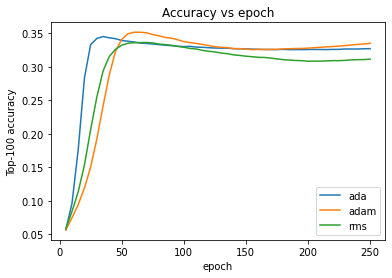

In [63]:
num_validation_runs = len(rmsOhOhOne["factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, adaOhOne.history["factorized_top_k/top_100_categorical_accuracy"], label="ada")
plt.plot(epochs, adamOhOhOne.history["factorized_top_k/top_100_categorical_accuracy"], label="adam")
plt.plot(epochs, rmsOhOhOne["factorized_top_k/top_100_categorical_accuracy"], label="rms")
#plt.plot(RMS_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="RMS .01")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [74]:
maxAdam = max(adamOhOhOne.history["factorized_top_k/top_100_categorical_accuracy"])

In [75]:
maxAda = max(adaOhOne.history["factorized_top_k/top_100_categorical_accuracy"])

In [76]:
adaOhOne.history["factorized_top_k/top_100_categorical_accuracy"].index(maxAda)  #6

6

In [77]:
adamOhOhOne.history["factorized_top_k/top_100_categorical_accuracy"].index(maxAdam)   #12

12

The result is a model that performs roughly as well on both tasks as each specialized model. 

While the results here do not show a clear accuracy benefit from a joint model in this case, multi-task learning is in general an extremely useful tool. We can expect better results when we can transfer knowledge from a data-abundant task (such as clicks) to a closely related data-sparse task (such as purchases).

In [79]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends movies out of the entire movies dataset.
index.index(movies.batch(1000).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(tf.constant(["80"]))
print(f"Recommendations for user 80: {titles[0, :]}")

Recommendations for user 80: [b'Citizen Kane (1941)' b'Room with a View, A (1986)'
 b'Third Man, The (1949)' b'Graduate, The (1967)'
 b'Raise the Red Lantern (1991)' b'Roman Holiday (1953)'
 b'It Happened One Night (1934)' b'Killing Fields, The (1984)'
 b'Annie Hall (1977)' b'Cinema Paradiso (1988)']
